# Employee Attrition Prediction

This project aims to build a predictive model to identify employees who are likely to leave the company ("Attrition = Yes"). Understanding the factors that influence attrition can help organizations improve employee retention and reduce hiring and training costs.

We use the IBM HR Analytics Employee Attrition & Performance dataset, which contains various features about employee demographics, job roles, compensation, satisfaction scores, and more.


In [330]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline

#imports for plotly
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss, classification_report, roc_auc_score, f1_score
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

## Dataset Overview

We begin by loading and exploring the dataset to understand its structure, features, and target variable. The dataset contains both numerical and categorical variables, and the target column is `'Attrition'`, with values "Yes" and "No".

Key columns include:
- Age, Gender, Department, DistanceFromHome, Education
- JobRole, MonthlyIncome, YearsAtCompany, OverTime
- Satisfaction metrics (e.g., JobSatisfaction, EnvironmentSatisfaction)


## Exploratory Data Analysis

In [236]:
#load data
attrition = pd.read_csv("Employee_Attrition.csv")
print(attrition.columns)

Index(['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department',
       'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount',
       'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate',
       'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction',
       'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'Over18', 'OverTime', 'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager'],
      dtype='object')


In [204]:
print(attrition.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

In [205]:
print("Shape: ",attrition.shape)
print(" ")
print(attrition.describe())

Shape:  (1470, 35)
 
               Age    DailyRate  DistanceFromHome    Education  EmployeeCount  \
count  1470.000000  1470.000000       1470.000000  1470.000000         1470.0   
mean     36.923810   802.485714          9.192517     2.912925            1.0   
std       9.135373   403.509100          8.106864     1.024165            0.0   
min      18.000000   102.000000          1.000000     1.000000            1.0   
25%      30.000000   465.000000          2.000000     2.000000            1.0   
50%      36.000000   802.000000          7.000000     3.000000            1.0   
75%      43.000000  1157.000000         14.000000     4.000000            1.0   
max      60.000000  1499.000000         29.000000     5.000000            1.0   

       EmployeeNumber  EnvironmentSatisfaction   HourlyRate  JobInvolvement  \
count     1470.000000              1470.000000  1470.000000     1470.000000   
mean      1024.865306                 2.721769    65.891156        2.729932   
std        6

In [394]:
print(attrition.isna().sum())
print(attrition.duplicated().sum())

Age                         0
Attrition                   0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsInCurrentRole          0
YearsSinceLastPromotion     0
YearsWithCurrManager        0
dtype: int64
0


There are no missing or duplicated values.

## Data Preprocessing

We perform the following preprocessing steps:
- Encoding The target variable (`Attrition`) into a binary format: 1 = Yes, 0 = No
- Convert categorical variables into numerical format using one-hot encoding
- Drop any columns that do not contribute to the prediction (e.g., EmployeeNumber, EmployeeCount, Over18, StandardHours)

In [344]:
print(attrition["Over18"].unique())
print(attrition["StandardHours"].unique())
print(attrition["EmployeeCount"].unique())

['Y']
[80]
[1]


In [354]:
attrition = attrition.drop(["Over18","StandardHours","EmployeeNumber","EmployeeCount"], axis = 1)

In [356]:
attrition["Attrition"].value_counts(normalize=True)

Attrition
No     0.838776
Yes    0.161224
Name: proportion, dtype: float64

We can see that there is a class imbalance here, where only 16% of the employees have Attrition set to "Yes". We will have to deal with these class imbalances in later sections.

## Exploratory Data Analysis (EDA)

We explore the distribution of features and how they relate to attrition using:
- Countplots for categorical features
- KDE plots to visualize relationships between continuous variables
- Correlation matrix for numerical variables

This helps us understand which factors might be most predictive of attrition.


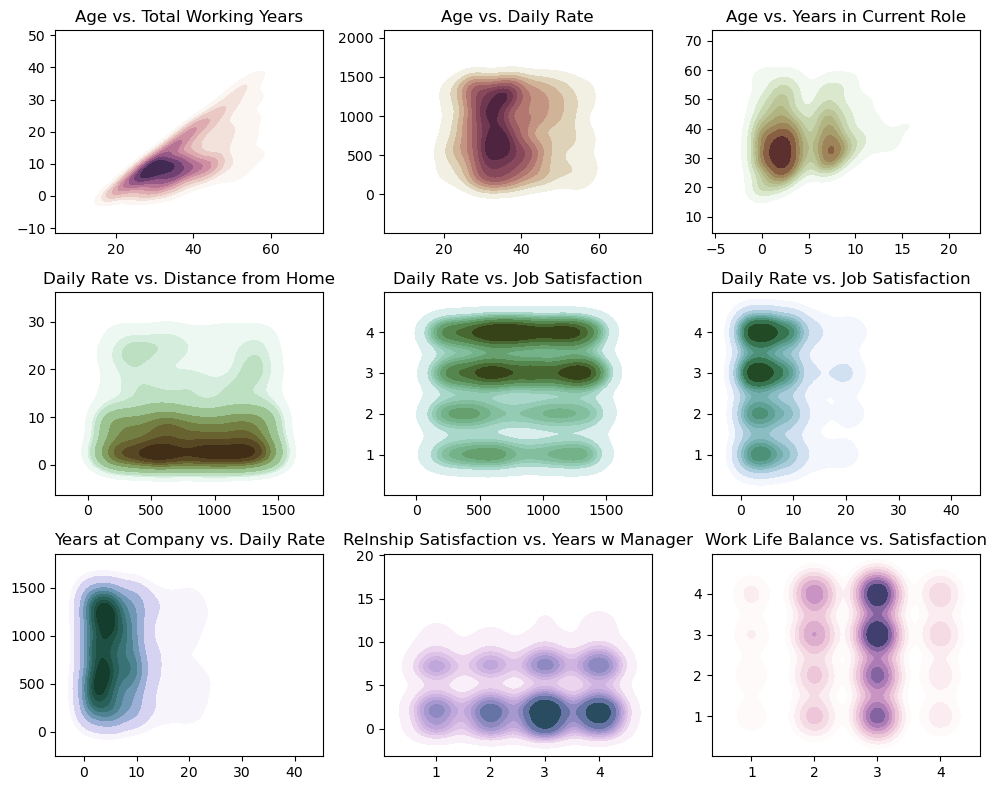

In [359]:
f,axes = plt.subplots(3,3,figsize=(10,8), sharex=False,sharey=False)

#Defining colormap scheme
s = np.linspace(0,3,10)
cmap = sns.cubehelix_palette(start=0.0,light=1, as_cmap = True)

#Generate and plot
x = attrition["Age"].values
y = attrition["TotalWorkingYears"].values
sns.kdeplot(x=x,y=y, cmap=cmap, fill = True, cut = 5, ax = axes[0,0])
axes[0,0].set(title = "Age vs. Total Working Years")

cmap = sns.cubehelix_palette(start=0.333333333333, light=1, as_cmap=True)
x = attrition["Age"].values
y = attrition["DailyRate"].values
sns.kdeplot(x=x,y=y, cmap=cmap, fill = True, cut = 5, ax = axes[0,1])
axes[0,1].set(title = "Age vs. Daily Rate")

cmap = sns.cubehelix_palette(start = 0.6666666, light = 1, as_cmap = True)
y = attrition["Age"].values
x = attrition["YearsInCurrentRole"].values
sns.kdeplot(x=x,y=y, cmap=cmap, fill = True, cut = 5, ax = axes[0,2])
axes[0,2].set(title = "Age vs. Years in Current Role")

cmap = sns.cubehelix_palette(start=1.0, light=1, as_cmap=True)
# Generate and plot
x = attrition['DailyRate'].values
y = attrition['DistanceFromHome'].values
sns.kdeplot(x=x,y=y, cmap=cmap, fill=True,  ax=axes[1,0])
axes[1,0].set( title = 'Daily Rate vs. Distance from Home')

cmap = sns.cubehelix_palette(start=1.333333333333, light=1, as_cmap=True)
# Generate and plot
x = attrition['DailyRate'].values
y = attrition['JobSatisfaction'].values
sns.kdeplot(x=x,y=y, cmap=cmap, fill=True,  ax=axes[1,1])
axes[1,1].set( title = 'Daily Rate vs. Job Satisfaction')

cmap = sns.cubehelix_palette(start=1.666666666667, light=1, as_cmap=True)
# Generate and plot
x = attrition['YearsAtCompany'].values
y = attrition['JobSatisfaction'].values
sns.kdeplot(x=x,y=y, cmap=cmap, fill=True,  ax=axes[1,2])
axes[1,2].set( title = 'Daily Rate vs. Job Satisfaction')

cmap = sns.cubehelix_palette(start=2.0, light=1, as_cmap=True)
# Generate and plot
x = attrition['YearsAtCompany'].values
y = attrition['DailyRate'].values
sns.kdeplot(x=x,y=y, cmap=cmap, fill=True,  ax=axes[2,0])
axes[2,0].set( title = 'Years at Company vs. Daily Rate')

cmap = sns.cubehelix_palette(start=2.333333333333, light=1, as_cmap=True)
# Generate and plot
x = attrition['RelationshipSatisfaction'].values
y = attrition['YearsWithCurrManager'].values
sns.kdeplot(x=x,y=y, cmap=cmap, fill=True,  ax=axes[2,1])
axes[2,1].set( title = 'Relnship Satisfaction vs. Years w Manager')

cmap = sns.cubehelix_palette(start=2.666666666667, light=1, as_cmap=True)
# Generate and plot
x = attrition['WorkLifeBalance'].values
y = attrition['JobSatisfaction'].values
sns.kdeplot(x=x,y=y, cmap=cmap, fill=True,  ax=axes[2,2])
axes[2,2].set( title = 'Work Life Balance vs. Satisfaction')

f.tight_layout()

### Interpretation:
* Age vs. Total Working Years: Strong positive correlation; Older employees tend to have more total working years
* Years at Company vs. Daily Rate: Slight clustering in lower years at company over a wide range of daily rates
* Work-Life Balance vs. Job Satisfaction: Highest density where scores are 3 or 4, suggesting that people with good work-life balance have higher job satisfaction.

There aren't any other significant relationships in this data. 

## Finding Correlation

In [362]:
#Use pandas apply method to numerically encode the target variable
attrition["Attrition_numeric"] = attrition["Attrition"].map({"No":0,"Yes":1})

#creating a list of only numeric variables
numeric = [u'Age', u'DailyRate', u'DistanceFromHome', 
             u'Education', u'EnvironmentSatisfaction',
             u'HourlyRate', u'JobInvolvement', u'JobLevel', u'JobSatisfaction',
             u'MonthlyIncome', u'MonthlyRate', u'NumCompaniesWorked',
             u'PercentSalaryHike', u'PerformanceRating', u'RelationshipSatisfaction',
             u'StockOptionLevel', u'TotalWorkingYears',
             u'TrainingTimesLastYear', u'WorkLifeBalance', u'YearsAtCompany',
             u'YearsInCurrentRole', u'YearsSinceLastPromotion',u'YearsWithCurrManager']

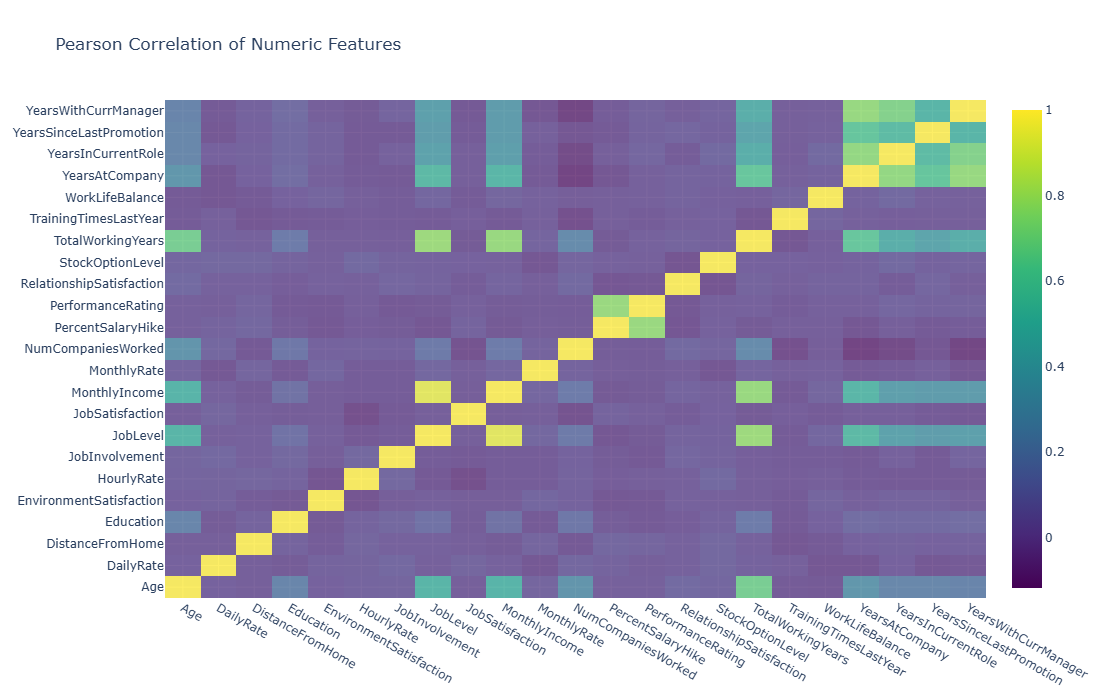

In [364]:
data = [go.Heatmap(
    z = attrition[numeric].astype(float).corr().values,
    x = attrition[numeric].columns.values,
    y = attrition[numeric].columns.values,
    colorscale = "Viridis",
    reversescale = False,
    opacity = 0.7
)]

layout = go.Layout(
    title = "Pearson Correlation of Numeric Features",
    xaxis = dict(ticks='',nticks=36),
    yaxis = dict(ticks=''),
    width = 900, height = 700,
)

fig = go.Figure(data = data, layout=layout)
py.iplot(fig, filename = "labelled-heatmap")

From the correlation plot, we can see that most of our columns are poorly correlated with each other, which is a good thing while building a predictive model so that we don't need to deal with redundant features.

## Feature Engineering
We will separate numeric columns from categorical columns and encode the categorical values in the dataset.

In [368]:
attrition = attrition.drop(["Attrition_numeric"],axis=1)

#using list comprehension to create a list of categorical variables only
categorical = [col for col in attrition.columns if attrition[col].dtype == "object"]
print(categorical)

#storing numeric columns in a separate list
numeric_col = attrition.columns.difference(categorical)

['Attrition', 'BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'OverTime']


In [370]:
#creating separate dataframes 
attrition_cat = attrition[categorical]
attrition_num = attrition[numeric_col]

#drop the target variable
attrition_cat = attrition_cat.drop(["Attrition"],axis = 1)

attrition_cat = pd.get_dummies(attrition_cat)
attrition_cat.head()


,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Human Resources,Department_Research & Development,Department_Sales,EducationField_Human Resources,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,...,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes
0,False,False,True,False,False,True,False,True,False,False,...,False,False,False,True,False,False,False,True,False,True
1,False,True,False,False,True,False,False,True,False,False,...,False,False,True,False,False,False,True,False,True,False
2,False,False,True,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,True
3,False,True,False,False,True,False,False,True,False,False,...,False,False,True,False,False,False,True,False,False,True
4,False,False,True,False,True,False,False,False,False,True,...,False,False,False,False,False,False,True,False,True,False


In [374]:
#creating a final dataframe with encoded categorical variables 
X = pd.concat([attrition_num,attrition_cat],axis = 1)

In [376]:
#Use pandas apply method to numerically encode the target variable
y = attrition["Attrition"].map({"Yes":1,"No":0})
y.head()

0    1
1    0
2    1
3    0
4    0
Name: Attrition, dtype: int64

## Machine Learning for Attrition Prediction
We will be using a variety of models for classification and checking to see which model has the best performance.

## Handling Class Imbalance

The dataset is imbalanced, with significantly more "No" (non-attrition) cases than "Yes" (attrition). 
To address this, we use **SMOTE (Synthetic Minority Oversampling Technique)** to balance the training dataset. This improves the model's ability to detect attrition cases.


In [384]:
#split data into training and test set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state = 23)

#There is a class imbalance among Attrition values, so we train the model with SMOTE
sm = SMOTE(random_state=23)
X_train_res, y_train_res = sm.fit_resample(X_train,y_train)

print("Before SMOTE: ", y_train.value_counts())
print("After SMOTE: ", y_train_res.value_counts())

Before SMOTE:  Attrition
0    986
1    190
Name: count, dtype: int64
After SMOTE:  Attrition
0    986
1    986
Name: count, dtype: int64


In [299]:
#empty list to store results
results = []

models = {
    "Random Forest Classifier": RandomForestClassifier(random_state=23),
    "Gradient Boosting Classifier": GradientBoostingClassifier(random_state=23),
    "XGBoost Classifier": XGBClassifier(random_state=23)
}

for name, model in models.items():
    model.fit(X_train_res, y_train_res)
    pred = model.predict(X_test)
    proba = model.predict_proba(X_test)[:,1]

    accuracy = accuracy_score(y_test,pred)
    f1 = f1_score(y_test,pred)
    auc = roc_auc_score(y_test,proba)
    results.append((name, accuracy,f1,auc))

results_df = pd.DataFrame(results, columns=["Model", "Accuracy","F1-Score", "ROC-AUC"])
print(results_df.sort_values(by="ROC-AUC", ascending=False))

                          Model  Accuracy  F1-Score   ROC-AUC
0      Random Forest Classifier  0.857143  0.322581  0.810492
1  Gradient Boosting Classifier  0.843537  0.303030  0.805496
2            XGBoost Classifier  0.846939  0.347826  0.785339


Out of the three models that we tested, **Random Forest Classifier** has the highest accuracy.

## Conclusion

- The dataset is highly imbalanced, which affects model performance.
- SMing significantly imprsove the ability to detect attrition casass.
- This model can be integrated into HR decision systems to proactively identify at-risk employees.

Further improvements could include:
- Feature engineering (e.g., interaction terms)
- Explainability tools like SHAP values
- Deploying the model in a real-time HR dashboard
